In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotnine import *
import itertools
from nilearn import image, plotting, datasets, masking
import nibabel as nib
import pdb
import os
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template

In [ ]:
study='hemispace'

patient_dir = f"/lab_data/behrmannlab/vlad/{study}"

control_dir = f"/lab_data/behrmannlab/vlad/spaceloc"
suf = '_roi'
exps = ['spaceloc','toolloc']
copes = [1,1]
p_hemi = ['right']
c_hemi = ['left', 'right']

c_subs =["spaceloc1001", "spaceloc1002", "spaceloc1003", "spaceloc1004", "spaceloc1005", "spaceloc1006", "spaceloc1007",
"spaceloc1008" ,"spaceloc1009", "spaceloc1010", "spaceloc1011" ,"spaceloc1012",
"spaceloc2013","spaceloc2014","spaceloc2015","spaceloc2016" ]

p_subs = ['hemispace1001']

#left is negative, right is positive
mni = load_mni152_brain_mask()
mni_affine = mni.affine

In [ ]:
ss = p_subs[0]
sub_dir = f'{patient_dir}/sub-{ss[1]}/ses-01/derivatives/'
anat_mask = image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-hemispace1001_ses-01_T1w_brain_mask.nii.gz')


In [263]:
#load hemisubj
control_summary = pd.DataFrame(columns=[['l' + exp for exp in exps] + ['r' + exp for exp in exps]])
p_acts = []
for exp in enumerate(exps):

    '''
    Extract activation spread from patients
    '''
    for ss in enumerate(p_subs):
        #set up dirs
        sub_dir = f'{patient_dir}/sub-{ss[1]}/ses-01/derivatives/'
        stat_dir = f'{sub_dir}/fsl/{exp[1]}/HighLevel{suf}.gfeat/cope{copes[exp[0]]}.feat/'

        #load anat
        anat_mask = image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-hemispace1001_ses-01_T1w_brain_mask.nii.gz')
        affine = anat_mask.affine
        hemi_mask = image.get_data(anat_mask)

        #extract just one hemi
        mid = list((np.array((anat_np.shape))/2).astype(int)) #find mid point of image
        hemi_mask[hemi_mask>0] = 1 #ensure to mask all of it

        if p_hemi[ss[0]] == 'left':
            hemi_mask[mid[0]:, :, :] = 0 
        else:
            hemi_mask[:mid[0], :, :] = 0 

        mask_size = np.sum(hemi_mask)
        #hemi_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image

        zstat = image.get_data(image.load_img(f'{stat_dir}/stats/zstat1.nii.gz'))
        clust_mask = image.get_data(image.load_img(f'{stat_dir}/cluster_mask_zstat1.nii.gz'))
        clust_mask[clust_mask>0] = 1

        zstat_mask = zstat  * hemi_mask * clust_mask

        p_spread = np.sum(zstat_mask)/mask_size
        p_acts.append(p_spread)

    

    '''
    Extract activation spread from controls
    '''
    act_spread = []
    for ss in enumerate(c_subs):
        #set up dirs
        sub_dir = f'{control_dir}/sub-{ss[1]}/ses-01/derivatives/'
        stat_dir = f'{sub_dir}/fsl/{exp[1]}/HighLevel{suf}.gfeat/cope{copes[exp[0]]}.feat/'

        hemi_spread = []
        for hemi in c_hemi:
            mni = load_mni152_brain_mask()
            hemi_mask = image.get_data(mni)
            mni_mask[mni_mask>0] = 1 #ensure to mask all of it
                        
            if hemi == 'left':
                hemi_mask[mid[0]:, :, :] = 0 
            else:
                hemi_mask[:mid[0], :, :] = 0 
            
            mask_size = np.sum(hemi_mask)
            #hemi_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image

            zstat = image.get_data(image.load_img(f'{stat_dir}/stats/zstat1.nii.gz'))
            
            clust_mask = image.get_data(image.load_img(f'{stat_dir}/cluster_mask_zstat1.nii.gz'))
            clust_mask[clust_mask>0] = 1

            zstat_mask = zstat *  hemi_mask * clust_mask
            
            act_val =np.sum(zstat_mask)/mask_size
            if act_val == 0:
                hemi_spread.append(np.nan)
            else:    
                hemi_spread.append(act_val)

        act_spread.append(hemi_spread)

    act_spread = np.array(act_spread)
    control_summary[f'l{exp[1]}'] = act_spread[:,0]
    control_summary[f'r{exp[1]}'] = act_spread[:,1]

p_acts = pd.Series(p_acts, index= exps) #create index for patients

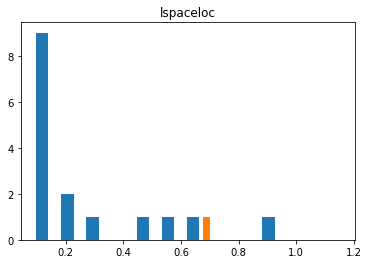

lspaceloc


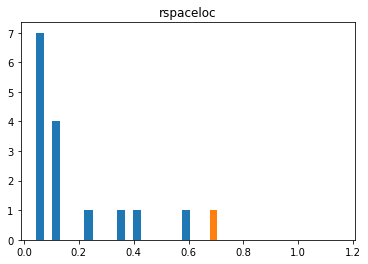

rspaceloc


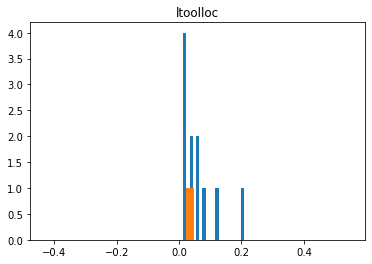

ltoolloc


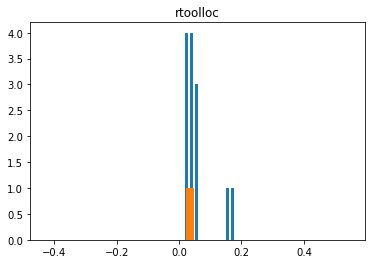

rtoolloc


In [269]:
for exp in exps:
    for lr in ['l','r']:
        plt.title(f'{lr}{exp}')
        plt.hist(df_summary[f'{lr}{exp}'], rwidth = .5)
        plt.hist(p_acts[exp], 20, rwidth = .5)
        plt.pause(0.0001)
        print(f'{lr}{exp}')
        

In [265]:
p_acts['spaceloc']

0.6652424653839574

In [258]:
p_acts[0]

0.6652424653839574

In [253]:
df_summary.mean()

lspaceloc    0.272156
ltoolloc     0.059526
rspaceloc    0.167944
rtoolloc     0.060327
dtype: float64

In [94]:
f'{stat_dir}/stats/zstat1.nii.gz'

'/lab_data/behrmannlab/vlad/hemispace/sub-hemispace1001/ses-01/derivatives//fsl/toolloc/HighLevel_roi.gfeat/cope1.feat//stats/zstat1.nii.gz'

In [62]:
anat_np = image.get_data(anat)
mid = list((np.array((anat_np.shape))/2).astype(int))
anat_np[anat_np>0] = 1
anat_np[mid[0]:, :, :] = 0 
rh_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image
print(mid)

[64, 80, 80]


In [71]:
anat_np[anat_np>0] = 1
anat_np[mid[0]:, :, :] = 0 
rh_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image


In [ ]:
hemi_mask

In [77]:
anat_np = image.get_data(anat)
anat_test = nib.Nifti1Image(anat_np, affine)  # create the volume image